# QFIE for Inverse Pendulum Control

This notebook aims to illustrate how QFIE can control efficiently an inverse pendulum system. The system configuration is reported in the related paper 'On the Implementation of Fuzzy Inference Engines on Quantum Computers - G. Acampora, R. Schiattarella and A.Vitiello', submitted to IEEE Transaction on Fuzzy Systems.

___

Firstly, let us define universe of discourse and fuzzy partition for the two input variables $\theta$ and $\omega$ and for the output variable $I$.
<b>Please, note that for executing QFIE you need to specify your IBMQ provider.</b>
(See https://quantum-computing.ibm.com for informations about IBMQ providers).

In [2]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import QFIE
from qiskit import IBMQ

IBMQ.enable_account('INSERT YOUR TOCKEN')
provider = IBMQ.get_provider(hub='HUB',group='GROUP', project='PROJECT')

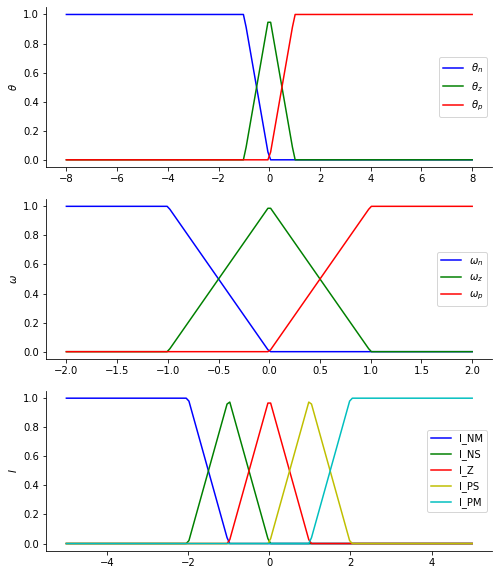

In [6]:
###  SYSTEM DEFINITION
theta = np.linspace(-8, 8, 150)
omega = np.linspace(-2, 2, 150)
current = np.linspace(-5, 5, 150)

theta_neg = fuzz.trapmf(theta, [-8, -8, -1, 0])
theta_zero = fuzz.trimf(theta, [-1, 0, 1])
theta_pos = fuzz.trapmf(theta, [0, 1, 8, 8])

omega_neg = fuzz.trapmf(omega, [-2, -2, -1, 0])
omega_zero = fuzz.trimf(omega, [-1, 0, 1])
omega_pos = fuzz.trapmf(omega, [0, 1, 2, 2])

current_neg_medium = fuzz.trapmf(current, [-5, -5, -2, -1])
current_neg_small = fuzz.trimf(current, [-2, -1, 0])
current_zero = fuzz.trimf(current, [-1, 0, 1])
current_pos_small = fuzz.trimf(current, [0, 1, 2])
current_pos_medium = fuzz.trapmf(current, [1, 2, 5, 5])

# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 10))

ax0.plot(theta, theta_neg, 'b', linewidth=1.5, label=r'$\theta_n$')
ax0.plot(theta, theta_zero, 'g', linewidth=1.5, label=r'$\theta_z$')
ax0.plot(theta, theta_pos, 'r', linewidth=1.5, label=r'$\theta_p$')
#ax0.set_title(r'$\theta$')
ax0.set_ylabel(r'$\theta$')
ax0.legend()

ax1.plot(omega, omega_neg, 'b', linewidth=1.5, label=r'$\omega_n$')
ax1.plot(omega, omega_zero, 'g', linewidth=1.5, label=r'$\omega_z$')
ax1.plot(omega, omega_pos, 'r', linewidth=1.5, label=r'$\omega_p$')
#ax1.set_title(r'$\omega$')
ax1.set_ylabel(r'$\omega$')
ax1.legend()


ax2.plot(current, current_neg_medium, 'b', linewidth=1.5, label='I_NM')
ax2.plot(current, current_neg_small, 'g', linewidth=1.5, label='I_NS')
ax2.plot(current, current_zero, 'r', linewidth=1.5, label='I_Z')
ax2.plot(current, current_pos_small, 'y', linewidth=1.5, label='I_PS')
ax2.plot(current, current_pos_medium, 'c', linewidth=1.5, label='I_PM')
#ax2.set_title(r'$i$')
ax2.set_ylabel(r'$I$')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


plt.show()


### RULE BASE DEFINITION
rules = ['if theta is zero and omega is zero then current is zero',
         'if theta is zero and omega is neg then current is pos_small',
         'if theta is zero and omega is pos then current is neg_small',
         'if theta is pos and omega is zero then current is neg_small',
         'if theta is pos and omega is pos then current is neg_medium',
         'if theta is pos and omega is neg then current is zero',
         'if theta is neg and omega is zero then current is pos_small',
         'if theta is neg and omega is pos then current is zero',
         'if theta is neg and omega is neg then current is pos_medium']


### QFIE INITIALIZATION
qfie = QFIE.QFIE()
qfie.input_variable(name='theta', range=theta)
qfie.input_variable(name='omega', range=omega)
qfie.output_variable(name='current', range=current)

qfie.add_input_fuzzysets(var_name='theta', set_names=['neg', 'zero', 'pos'], sets=[theta_neg, theta_zero, theta_pos])
qfie.add_input_fuzzysets(var_name='omega', set_names=['neg', 'zero', 'pos'], sets=[omega_neg, omega_zero, omega_pos])
qfie.add_output_fuzzysets(var_name='current', set_names=['neg_medium', 'neg_small', 'zero', 'pos_small', 'pos_medium'],
                          sets=[current_neg_medium, current_neg_small, current_zero, current_pos_small, current_pos_medium])
qfie.set_rules(rules)



In the following cell it is possible to set the pendulum initial conditions and the number of calls to QFIE as well as the time step beteween each call:
- T: number of calls to QFIE
- t: time step 
- theta_0: initial angle of the pendulum
- omega_0: initial radial velocity of the pendulum

- g: if True gravity is considered, while if False g = 0

In [7]:
T = 600
t = 0.01
theta_0 = -2
omega_0 = 0

g = True

Then, run the following cell to simulate the pendulum controlled by QFIE in the set environment. In the output you can monitor the status of the simulation, call by call to QFIE. For each call you will see:

   - The crisp value of the input variables
   - The fuzzified values used as input for QFIE
   - The Output Counts of QFIE
   - The computed value of $I$ 
   - The updated crisp values of $\theta$ and $\omega$


In [10]:
from math import sin, cos, radians, pi
from Backend import compute_current
import os
import  sys


class Mass():
    def __init__(self):
        self.theta = theta_0
        self.dtheta = omega_0
        self.points = [(self.theta, self.dtheta)]
        

    def recomputeAngle(self):
        
        if self.dtheta > 2 :
            self.dtheta = self.dtheta % 2
        if self.dtheta <-2 :
            self.dtheta = self.dtheta % (-2)
        if self.theta > 8 :
            self.theta = self.theta % 8
        if self.theta <-8 :
            self.theta = self.theta % (-8)
        qfie.build_inference_qc({'theta':self.theta, 'omega':self.dtheta}, draw_qc=False)

        current = qfie.execute(provider, 'qasm_simulator', 8000, plot_histo=False)[0]    
        print('I = ',current)
        l = 12
        tau = 100
        m = 1
        
        if g == True:
            theta_new = self.theta + self.dtheta *t + ((3* tau*100/(l*l))*current-(3*32/2)*cos(self.theta*pi/4)) *(t*t/2)
            omega_new = self.dtheta + ((3*tau*100/(l*l))*current-(3*32/2)*cos(self.theta*pi/4)) * t
        else: 
            theta_new = self.theta + self.dtheta *t + ((3* tau/(l*l))*current) *(t*t/2)
            omega_new = self.dtheta + ((3*tau/(l*l))*current) * t
        
        
        self.theta, self.dtheta = theta_new, omega_new
        print('theta_new =', theta_new, 'omega_new =', omega_new)
        self.points.append((theta_new, omega_new))

        
    def update(self):
        i=0
        while len(self.points)<T:
            print('Call n. ', i)
            self.recomputeAngle()
            i+=1
        return self.points
            
bob = Mass()
points = bob.update()
theta_quantum, omega_quantum = [], []
for p in points:
    theta_quantum.append(p[0])
    omega_quantum.append(p[1])

Call n.  0
{'theta': -2, 'omega': 0}
Input values  {'theta': [1.0, 0.0, 0.0], 'omega': [0.006711409395973089, 0.9865771812080538, 0.006711409395973089]}
Output Counts {'00001': 0, '00010': 0, '00100': 0.006625, '01000': 0.987375, '10000': 0.006}
I =  1.0339668520322254
theta_new = -1.9892295119579977 omega_new = 2.1540976084004697
Call n.  1
{'theta': -1.9892295119579977, 'omega': 0.1540976084004697}
Input values  {'theta': [1.0, 0.0, 0.0], 'omega': [0.0, 0.8459023915995303, 0.1540976084004697]}
Output Counts {'00001': 0, '00010': 0, '00100': 0.157875, '01000': 0.842125, '10000': 0}
I =  0.8014713227096759
theta_new = -1.979360177911977 omega_new = 1.819769200803692
Call n.  2
{'theta': -1.979360177911977, 'omega': 1.819769200803692}
Input values  {'theta': [1.0, 0.0, 0.0], 'omega': [0.0, 0.0, 1.0]}
Output Counts {'00001': 0, '00010': 0, '00100': 1.0, '01000': 0, '10000': 0}
I =  -5.74653035523237e-18
theta_new = -1.961201389348115 omega_new = 1.8119885119686914
Call n.  3
{'theta': -1

___

At this point, a classical Mamdani fuzzy inference system is implemented using scikit-fuzzy so as to compare the quantum control to a classical one. The pendulum environment is the same of the one set before. 

In [11]:
from math import sin, cos, pi
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import os
import sys



# New Antecedent/Consequent objects hold universe variables and membership
# functions
theta = ctrl.Antecedent(np.linspace(-8, 8, 150), 'theta')
omega = ctrl.Antecedent( np.linspace(-2, 2 , 150), 'omega')
current = ctrl.Consequent(np.linspace(-5, 5, 150), 'current')


# Custom membership functions can be built interactively with a familiar,
# Pythonic API
theta['neg'] = fuzz.trapmf(theta.universe, [-8, -8, -1, 0])
theta['zero'] = fuzz.trimf(theta.universe, [-1, 0, 1])
theta['pos'] = fuzz.trapmf(theta.universe, [0, 2, 8, 8])

omega['neg'] = fuzz.trapmf(omega.universe, [-2, -2, -1, 0])
omega['zero'] = fuzz.trimf(omega.universe, [-1, 0, 1])
omega['pos'] = fuzz.trapmf(omega.universe, [0,1, 2, 2])

current['neg_medium'] = fuzz.trapmf(current.universe, [-5, -5, -2, -1])
current['neg_small'] = fuzz.trimf(current.universe, [-2, -1, 0])
current['zero'] = fuzz.trimf(current.universe, [-1, 0, 1])
current['pos_small'] = fuzz.trimf(current.universe, [0, 1, 2])
current['pos_medium'] = fuzz.trapmf(current.universe, [1, 2, 5, 5])


rule1 = ctrl.Rule(theta['zero'] & omega['zero'], current['zero'])
rule2 = ctrl.Rule(theta['zero'] & omega['neg'], current['pos_small'])
rule3 = ctrl.Rule(theta['zero'] & omega['pos'], current['neg_small'])
rule4 = ctrl.Rule(theta['pos'] & omega['zero'], current['neg_small'])
rule5 = ctrl.Rule(theta['pos'] & omega['pos'], current['neg_medium'])
rule6 = ctrl.Rule(theta['pos'] & omega['neg'], current['zero'])
rule7 = ctrl.Rule(theta['neg'] & omega['zero'], current['pos_small'])
rule8 = ctrl.Rule(theta['neg'] & omega['pos'], current['zero'])
rule9 = ctrl.Rule(theta['neg'] & omega['neg'], current['pos_medium'])

pendulum_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
pendulum = ctrl.ControlSystemSimulation(pendulum_ctrl)


class c_Mass():
    def __init__(self):
        self.theta = theta_0
        self.dtheta =  omega_0
        self.points = [(self.theta, self.dtheta)]
        
    def recomputeAngle(self):
        if self.dtheta > 2 :
            self.dtheta = self.dtheta % 2
        if self.dtheta <-2 :
            self.dtheta = self.dtheta % (-2)
        if self.theta > 8 :
            self.theta = self.theta % 8
        if self.theta <-8 :
            self.theta = self.theta % (-8)    
        
        pendulum.input['theta']=self.theta
        pendulum.input['omega']=self.dtheta
        pendulum.compute()
        current = pendulum.output['current']
        print('I = ',current)
        
        l = 12
        tau = 100
        m = 1
        if g == True:
            theta_new = self.theta + self.dtheta *t + ((3* tau*100/(l*l))*current-(3*32/2)*cos(self.theta*pi/4)) *(t*t/2)
            omega_new = self.dtheta + ((3*tau*100/(l*l))*current-(3*32/2)*cos(self.theta*pi/4)) * t
        else: 
            theta_new = self.theta + self.dtheta *t + ((3* tau/(l*l))*current) *(t*t/2)
            omega_new = self.dtheta + ((3*tau/(l*l))*current) * t
        
        self.theta, self.dtheta = theta_new, omega_new
        print('theta_new =', theta_new, 'omega_new =', omega_new)
        self.points.append((theta_new, omega_new))

        
    def update(self):
        i=0
        while len(self.points)<T:
            print('Call n. ', i)
            i+=1
            self.recomputeAngle()
        return self.points
            
bob_c = c_Mass()
points_c = bob_c.update()
theta_c, omega_c = [], []
for p in points_c:
    theta_c.append(p[0])
    omega_c.append(p[1])

Call n.  0
I =  1.0386159633099346
theta_new = -1.9891810837155215 omega_new = 2.163783256895697
Call n.  1
I =  0.795292888296902
theta_new = -1.979279343158154 omega_new = 1.8165648545778235
Call n.  2
I =  -5.74653035523237e-18
theta_new = -1.9611527504063742 omega_new = 1.8087536957781551
Call n.  3
I =  -5.74653035523237e-18
theta_new = -1.9431384274286423 omega_new = 1.7941108997682427
Call n.  4
I =  -5.74653035523237e-18
theta_new = -1.9253044643461368 omega_new = 1.7726817167328386
Call n.  5
I =  -5.74653035523237e-18
theta_new = -1.9077183641971347 omega_new = 1.7445383130675822
Call n.  6
I =  -5.74653035523237e-18
theta_new = -1.890446775600475 omega_new = 1.7097794062643765
Call n.  7
I =  -5.74653035523237e-18
theta_new = -1.8735552297917584 omega_new = 1.668529755478972
Call n.  8
I =  -5.74653035523237e-18
theta_new = -1.8571078834358472 omega_new = 1.620939515703246
Call n.  9
I =  -5.74653035523237e-18
theta_new = -1.8411672685307303 omega_new = 1.567183465320123
Cal

Running the following cell it is possible to plot the trends of $\theta$ and $\omega$ controlled by QFIE compared to the ones controlled by the classical inference engine. 

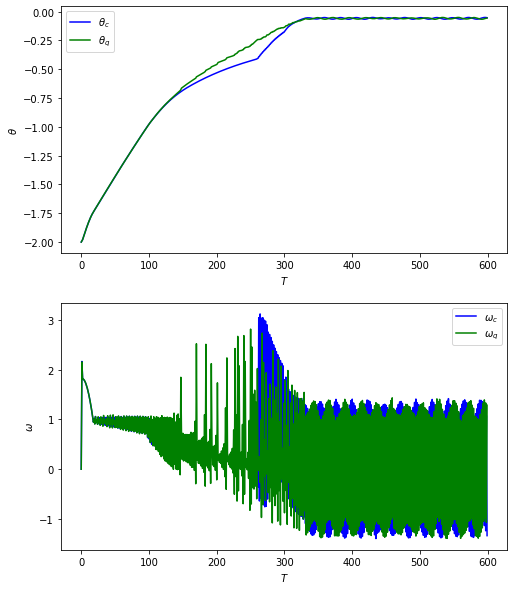

In [12]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(8, 10))

ax0.plot(theta_c, color='b', label=r'$\theta_c$')
ax0.plot(theta_quantum, color='g', label=r'$\theta_q$')
ax0.set_ylabel(r'$\theta$')
ax0.set_xlabel(r'$T$')
ax0.legend()

ax1.plot(omega_c, color='b', label=r'$\omega_c$')
ax1.plot(omega_quantum, color='g', label=r'$\omega_q$')
ax1.set_ylabel(r'$\omega$')
ax1.set_xlabel(r'$T$')
ax1.legend()



plt.show()





Finally, the following animation shows the pendulum controlled by the classical and the quantum fuzzy inference engine over the time set. The <b> Red </b> pendulum is controlled by the classical inference engine, the <b> Black</b> one by QFIE. 

<IPython.core.display.Javascript object>


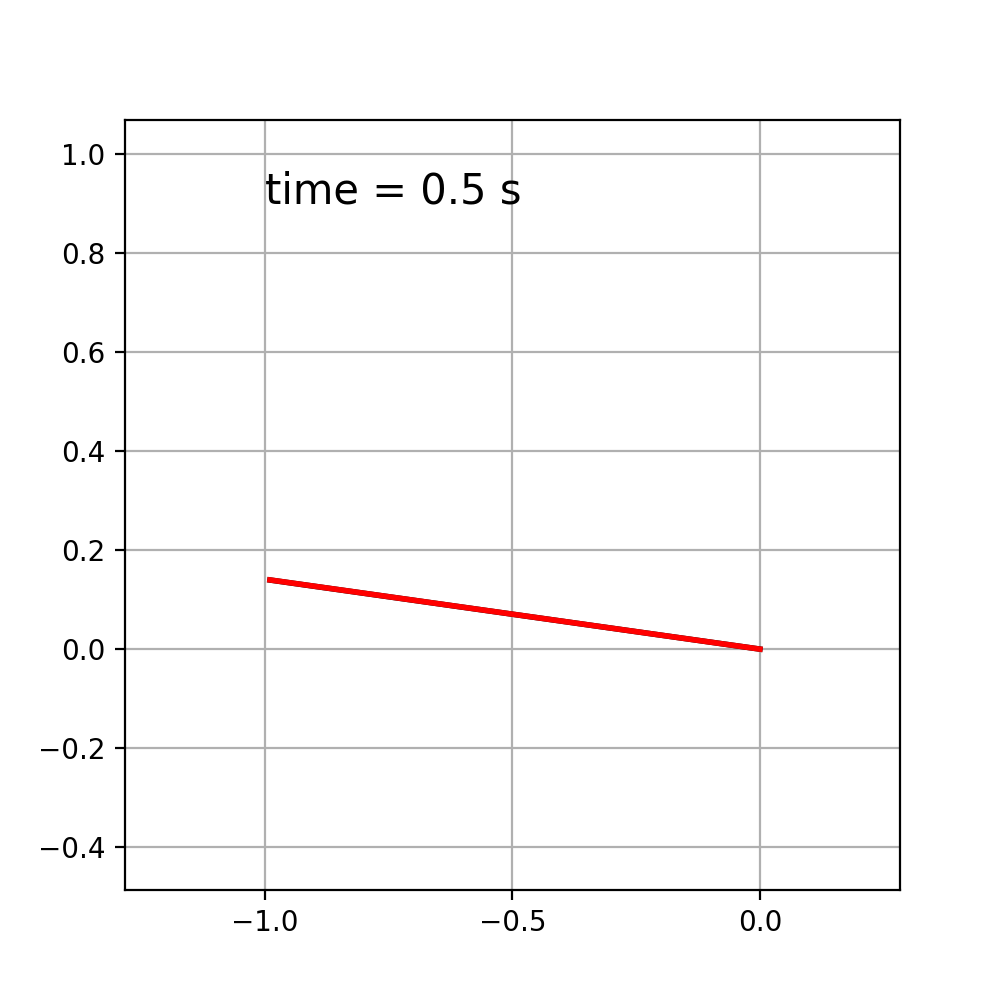

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [13]:
%matplotlib notebook
import math
from matplotlib import animation
fig = plt.figure(figsize=(5, 5), facecolor='w')
ax = fig.add_subplot(1, 1, 1)
plt.rcParams['font.size'] = 15
t_i=[i for i in range(T)]
lns = []
for i in range(T):
    ln, = ax.plot([0, math.sin(theta_quantum[i])], [0, math.cos(theta_quantum[i])],
                  color='k', lw=2, label='Quantum')
    ln_c, = ax.plot([0, math.sin(theta_c[i])], [0, math.cos(theta_c[i])],
                  color='r', lw=2, label='Classical')
    tm = ax.text(-1, 0.9, 'time = %.01f s' % (t_i[i]*t))
    lns.append([ln, ln_c, tm])


ax.set_aspect('equal', 'datalim')
ax.grid()
ani = animation.ArtistAnimation(fig, lns, interval=50)

plt.rcParams['animation.html'] = 'html5'
ani